In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchaudio.compliance.kaldi import mfcc

from utils.audio import print_stats, plot_waveform, plot_specgram, play_audio, plot_spectrogram

print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"torchaudio {torchaudio.__version__}")

Using torch 1.9.1 (NVIDIA GeForce RTX 3060 Laptop GPU)
torchaudio 0.9.0a0+a85b239


In [4]:
wav_speech_path = 'data/Wikipedia_Audio_-_Carpenters_Hall.wav'
    
metadata = torchaudio.info(wav_speech_path)
print(metadata)

waveform, sample_rate = torchaudio.load(wav_speech_path)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)
waveform.shape

AudioMetaData(sample_rate=44100, num_frames=10456788, num_channels=2, bits_per_sample=16, encoding=PCM_S)


torch.Size([1, 10456788])

Sample Rate: 44100
Shape: (1, 10456788)
Dtype: torch.float32
 - Max:          1.000
 - Min:         -0.860
 - Mean:         0.000
 - Std Dev:      0.070

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



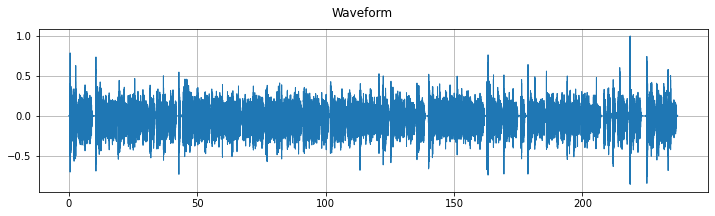

/home/xunwei/miniconda3/envs/asr/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


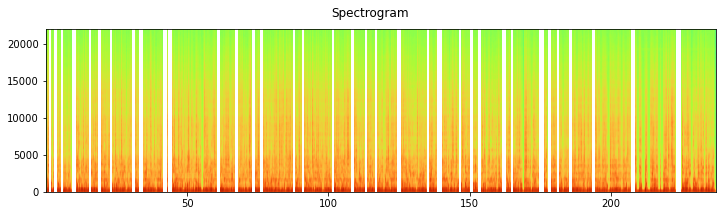

In [5]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
# play_audio(waveform, sample_rate)

### [Kaldi](https://pytorch.org/audio/stable/compliance.kaldi.html#mfcc)

``` python
torchaudio.compliance.kaldi.mfcc(waveform: torch.Tensor, blackman_coeff: float = 0.42, cepstral_lifter: float = 22.0, 
                                channel: int = -1, dither: float = 0.0, energy_floor: float = 1.0, frame_length: float = 25.0, 
                                frame_shift: float = 10.0, high_freq: float = 0.0, htk_compat: bool = False, 
                                low_freq: float = 20.0, num_ceps: int = 13, min_duration: float = 0.0, num_mel_bins: int = 23, 
                                preemphasis_coefficient: float = 0.97, raw_energy: bool = True, remove_dc_offset: bool = True, 
                                round_to_power_of_two: bool = True, sample_frequency: float = 16000.0, snip_edges: bool = True, 
                                subtract_mean: bool = False, use_energy: bool = False, vtln_high: float = -500.0, 
                                vtln_low: float = 100.0, vtln_warp: float = 1.0, window_type: str = 'povey')
```

In [ ]:
class ExtractAudioFeature(nn.Module):
    def __init__(self, mode="fbank", num_mel_bins=40, **kwargs):
        super(ExtractAudioFeature, self).__init__()
        self.mode = mode
        self.extract_fn = torchaudio.compliance.kaldi.fbank if mode == "fbank" else torchaudio.compliance.kaldi.mfcc
        self.num_mel_bins = num_mel_bins
        self.kwargs = kwargs

    def forward(self, filepath):
        waveform, sample_rate = torchaudio.load(filepath)

        y = self.extract_fn(waveform,
                            num_mel_bins=self.num_mel_bins,
                            channel=-1,
                            sample_frequency=sample_rate,
                            **self.kwargs)
        return y.transpose(0, 1).unsqueeze(0).detach()

    def extra_repr(self):
        return "mode={}, num_mel_bins={}".format(self.mode, self.num_mel_bins)

torch.Size([1, 220500])


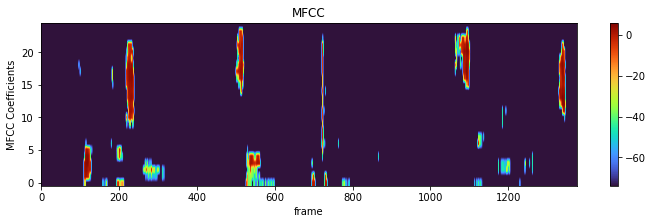

torch.Size([1, 132300])


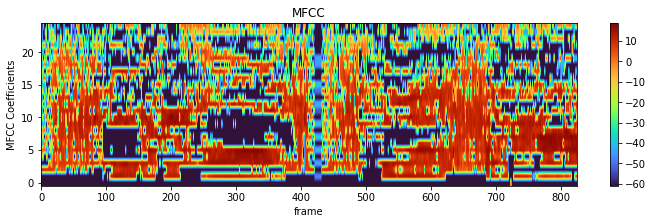

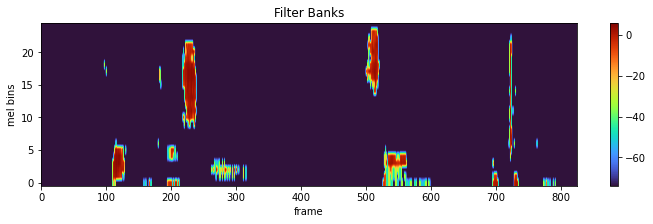

In [14]:
n_feats = 25

signal = waveform
signal = waveform[:, 0:int(3 * sample_rate)]
print(signal.shape)

waveform_trans = mfcc(signal, frame_length=25, num_ceps=n_feats, num_mel_bins=n_feats)
plot_spectrogram(waveform_trans.transpose(0, 1).detach(), title="MFCC", ylabel='MFCC Coefficients') # transpose(0, 1).unsqueeze(0).detach()

waveform_trans = torchaudio.compliance.kaldi.fbank(signal, frame_length=25, num_mel_bins=n_feats)
plot_spectrogram(waveform_trans.transpose(0, 1).detach(), title="Filter Banks", ylabel='mel bins')

### Test params

#### test MFCC

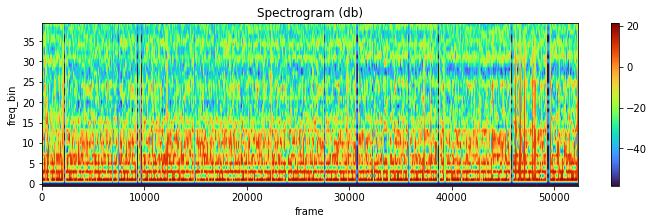

torch.Size([40, 52284])

In [46]:
sample_rate = 8000
n_feats = 40

transform = T.MFCC(sample_rate=sample_rate, melkwargs={'n_mels': n_feats})
spectogram = transform(waveform)
spectogram = torch.mean(spectogram, dim=0)#.unsqueeze(0)
plot_spectrogram(spectogram)
spectogram.shape

In [ ]:
sample_rate = 8000
n_feats = 60

transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_feats, melkwargs={'n_mels': n_feats, 'win_length': 5, 'hop_length': 5})
spectogram = transform(waveform)
spectogram = torch.mean(spectogram, dim=0)#.unsqueeze(0)
plot_spectrogram(spectogram, sample_rate)
spectogram.shape

#### test MelSpectrogram

In [21]:
transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=28, win_length=160, hop_length=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)
test = transforms(waveform)
test.shape

torch.Size([1, 28, 100674])

In [22]:
transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=28),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)
test = transforms(waveform)
test.shape

torch.Size([1, 28, 40270])

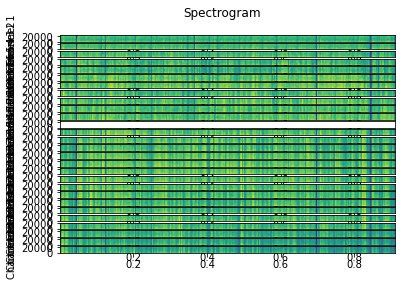

In [20]:
plot_specgram(test[0], sample_rate)

### MFCC

MFCC shape: torch.Size([2, 256, 15731])
MFCC reshaped: torch.Size([256, 15731])


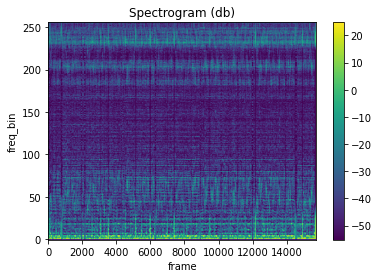

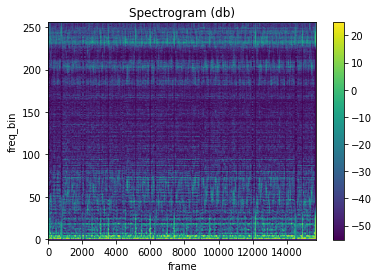

In [22]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)
mfcc = mfcc_transform(waveform)
mfcc_re = torch.mean(mfcc, dim=0)#.unsqueeze(0)
mfcc_re.shape

print(f'MFCC shape: {mfcc.shape}')
print(f'MFCC reshaped: {mfcc_re.shape}')

plot_spectrogram(mfcc[0])
plot_spectrogram(mfcc_re)

https://pytorch.org/audio/stable/transforms.html#mfcc

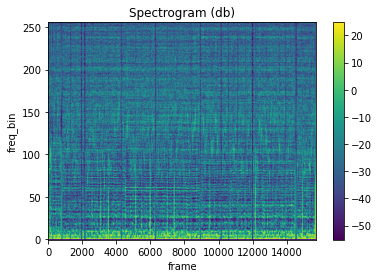

In [50]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=14000,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

## Data directory

In [6]:
import os
AUDIO_DIR = 'data/audio'
LABEL_DIR = 'data/label'

In [7]:
os.listdir(AUDIO_DIR)[0]

'Wikipedia_Audio_-_2_Broadway - Copy - Copy.wav'

In [8]:
os.path.join(AUDIO_DIR, os.listdir(AUDIO_DIR)[0])

'data/audio/Wikipedia_Audio_-_2_Broadway - Copy - Copy.wav'

In [9]:
for root, dirs, files in os.walk(AUDIO_DIR):
    print("Directory path: ", root)
    print("Folder name: ", dirs)
    print("File name: ", files)

Directory path:  data/audio
Folder name:  []
File name:  ['Wikipedia_Audio_-_2_Broadway - Copy - Copy.wav', 'Wikipedia_Audio_-_2_Broadway - Copy.wav', 'Wikipedia_Audio_-_2_Broadway.wav']


In [77]:
labels = []
for file in os.listdir(LABEL_DIR):
    if file.endswith('.txt'):
        filepath = os.path.join(LABEL_DIR, file)
        with open(filepath) as f_input:
            labels.append(f_input.read())

print(labels)

['2 Broadway\nFrom Wikipedia, the free encyclopedia\n\n2 Broadway is an office building at the south end of Broadway, near Bowling Green Park in New York City. 2 Broadway was built on the site of the Produce Exchange Building, and now houses the headquarters of the Metropolitan Transportation Authority.\nDescription and history\nNew York Produce Exchange (1883)\n\nThe Produce Exchange was a representative structure of brick with terracotta decorations. Its grand skylighted hall, based on French retail structures, cast daylight into the lower floors. Its architect was George B. Post, who built it from 1881–84.\n\nThe Produce Exchange Building was demolished in 1957 and replaced by a 32-story tower constructed in 1958-1959. The developer, Uris Buildings Corporation, first preferred a design by William Lescaze with Kahn & Jacobs, which featured a tower slab set at right angles to Broadway. However, ultimately Emery Roth & Sons was given the contract, which saw a radically different design